In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

import time
import sys

In [49]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data', download=True, train=False, transform=transform)

# Train and validation split
valid_size = 0.2
valid_index = np.random.choice(range(len(trainset)), int(valid_size*len(trainset)))
train_index = [i for i in range(len(trainset)) if i not in valid_index]
np.random.shuffle(train_index)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_index)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_index)

# Data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


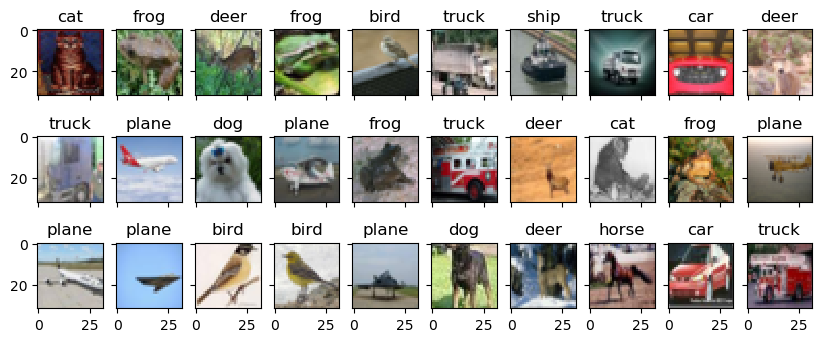

In [50]:
# specify the image classes
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

train_images, train_labels = next(iter(trainloader))
train_images, train_labels = train_images.numpy() / 2 + 0.5, train_labels.numpy()

valid_images, valid_labels = next(iter(validloader))
valid_images, valid_labels = valid_images.numpy() / 2 +0.5, valid_labels.numpy()

test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.numpy() / 2 + 0.5, test_labels.numpy()

fig, ax = plt.subplots(3,10, figsize=(10,4), dpi=100, sharex=True, sharey=True)
for i in range(ax.shape[1]):
    ax[0,i].imshow(train_images[i,:,:,:].transpose(1,2,0))
    ax[0,i].set_title(classes[train_labels[i]])
    
    ax[1,i].imshow(valid_images[i,:,:,:].transpose(1,2,0))
    ax[1,i].set_title(classes[valid_labels[i]])
    
    ax[2,i].imshow(test_images[i,:,:,:].transpose(1,2,0))
    ax[2,i].set_title(classes[test_labels[i]])
plt.show()

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Pooling layers
        self.pool = nn.MaxPool2d(2,2)
        # FC layers
        # Input image: 32 x 32. We apply pooling in 3 Conv layers.
        # So, output from conv3 is 4 x 4 x 64. Note: 32/2/2/2 = 4
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)
        # Dropout operations
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#     
model = Net()
print(model)

# Use negative log-likelihood loss and SGD optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [52]:
def compute_accurcay(logps, labels):
    ps = torch.exp(logps)
    _, pred_labels = ps.topk(1, dim=1)
    pred_labels = pred_labels.view(*labels.shape)
    equals = (pred_labels == labels).float()
    return float(torch.mean(equals))

In [53]:
def train_nn(model, trainloader, validloader, n_epochs=1):
    # Send model to GPU(s), if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    
    # Initialize losses and accuracies
    train_losses, valid_losses = [], [] # Train and test losses
    train_accs, valid_accs = [], [] # Train and test accuracies
    min_valid_loss = np.infty
    history = {}
    
    for iepoch in range(n_epochs):
        '''Training'''
        train_loss, train_acc = 0, 0
        for itrain, (images, labels) in enumerate(trainloader):
#             images = images.view(images.shape[0],-1)
            # Display progress
            progress_percent = (itrain+1)/len(trainloader)*100
            progress_bar = ['.']*int(progress_percent/(len(trainloader)/100))
            
            sys.stdout.write('\rEpoch: {}/{}..'.format(iepoch+1, n_epochs) \
                             +'Progress: {:0.2f}%..'.format(progress_percent))
            sys.stdout.flush()
            
            # Send data to device (GPU is available, CPU else)
            images, labels = images.to(device), labels.to(device)
            
            # Model training
            logps = model(images) # Forward pass
            loss = criterion(logps, labels)
            optimizer.zero_grad() # Refresh gradient for backpropagation
            loss.backward() # Backpropagation
            optimizer.step() # Update parameters
            
            # Accumulate loss and accuracy for every batch
            train_loss += loss.item()
            train_acc += compute_accurcay(logps, labels)
        # Record losses and accuracies for every epoch
        train_losses.append(train_loss/len(trainloader))
        train_accs.append(train_acc/len(trainloader))

        '''Validation'''
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            model.eval() # Disable dropout (if any) for prediction
            for images, labels in testloader:
#                 images = images.view(images.shape[0],-1)
                # Send data to GPU or CPU
                images, labels = images.to(device), labels.to(device)
                # Predict class probabilities and loss
                logps = model(images)
                loss = criterion(logps, labels)
                # Accumulate loss and accuracy
                valid_acc += compute_accurcay(logps, labels)
                valid_loss += loss.item()
        # Record losses and accuracies
        valid_losses.append(valid_loss/len(testloader))
        valid_accs.append(valid_acc/len(testloader))
        
        # Save model if current epoch gives minimum validation loss
        if valid_losses[iepoch] < min_valid_loss:
            history['model'] = model
        
         # Back to train mode by enabling dropout
        model.train()

        print('Training:',
              '(Loss={:0.3f},'.format(train_losses[iepoch]),
              'Accuracy={:0.3f})..'.format(train_accs[iepoch]),
              'Validation:',
              '(Loss={:.03f},'.format(valid_losses[iepoch]),
              'Accuracy={:0.3f})'.format(valid_accs[iepoch])
             )
    history['train_losses'] = train_losses
    history['valid_losses'] = valid_losses
    history['train_accs'] = train_accs
    history['valid_accs'] = valid_accs
    return history

In [54]:
tstart = time.time()
history = train_nn(model, trainloader, validloader, n_epochs=30)
tend = time.time()
print('Training time: ', tend - tstart)

Epoch: 1/30..Progress: 100.00%..Training: (Loss=2.046, Accuracy=0.250).. Validation: (Loss=1.814, Accuracy=0.337)
Epoch: 2/30..Progress: 100.00%..Training: (Loss=1.659, Accuracy=0.395).. Validation: (Loss=1.556, Accuracy=0.436)
Epoch: 3/30..Progress: 100.00%..Training: (Loss=1.483, Accuracy=0.461).. Validation: (Loss=1.386, Accuracy=0.492)
Epoch: 4/30..Progress: 100.00%..Training: (Loss=1.368, Accuracy=0.509).. Validation: (Loss=1.289, Accuracy=0.537)
Epoch: 5/30..Progress: 100.00%..Training: (Loss=1.272, Accuracy=0.544).. Validation: (Loss=1.207, Accuracy=0.573)
Epoch: 6/30..Progress: 100.00%..Training: (Loss=1.181, Accuracy=0.580).. Validation: (Loss=1.094, Accuracy=0.605)
Epoch: 7/30..Progress: 100.00%..Training: (Loss=1.107, Accuracy=0.607).. Validation: (Loss=1.158, Accuracy=0.592)
Epoch: 8/30..Progress: 100.00%..Training: (Loss=1.044, Accuracy=0.630).. Validation: (Loss=1.028, Accuracy=0.635)
Epoch: 9/30..Progress: 100.00%..Training: (Loss=0.985, Accuracy=0.652).. Validation: (Lo

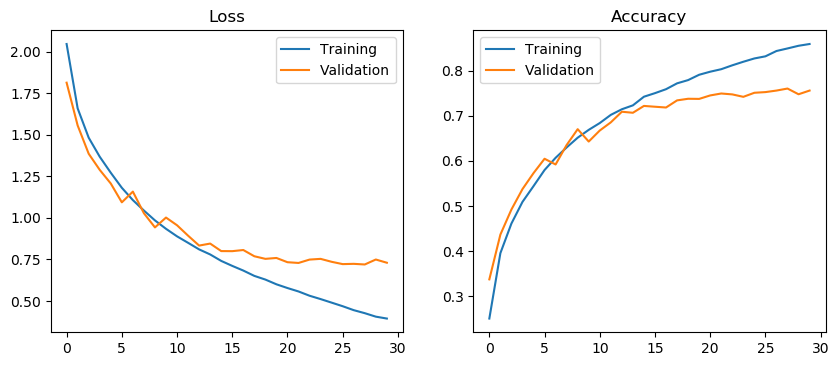

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=100)
ax[0].plot(history['train_losses'], label='Training')
ax[0].plot(history['valid_losses'], label='Validation')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(history['train_accs'], label='Training')
ax[1].plot(history['valid_accs'], label='Validation')
ax[1].legend()
ax[1].set_title('Accuracy')

plt.show()

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = history['model']
model.to(device)

with torch.no_grad():
    acc = 0
    model.eval() # Disable dropout (if any) for prediction
    for images, labels in testloader:
#         images = images.view(images.shape[0],-1)
        # Send data to GPU or CPU
        images, labels = images.to(device), labels.to(device)
        # Predict class probabilities and loss
        logps = model(images)
        acc += compute_accurcay(logps, labels)
    accuracy = acc / len(testloader)
print('Test accuracy: {:0.2f}%'.format(accuracy*100))

Test accuracy: 75.62%


In [80]:
def predict(model, testloader):
    device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    images, labels = next(iter(testloader))
#     flat_images = images.view(images.shape[0],-1)
    
    # Send data and model to GPU or CPU
    images, labels = images.to(device), labels.to(device)
    model.to(device)
    model.eval() # Disable dropout (if any) for prediction
    
    with torch.no_grad():
        logps = model(images) # log probabilities
    ps = torch.exp(logps) # probabilities
    pred_classes = ps.topk(1,dim=1)[1]
    pred_classes = pred_classes.view(*labels.shape)
    pred_classes = pred_classes.to('cpu').numpy()
    images, labels = images.numpy() / 2 + 0.5, labels.numpy()
        
    fig, ax = plt.subplots(1,10, figsize=(10,1), dpi=100, sharex=True, sharey=True)
    for i in range(10):
        ax[i].imshow(images[i,:,:,:].transpose(1,2,0))
        ax[i].set_title('T:'+classes[labels[i]] + '\nP:' +classes[pred_classes[i]])
    return pred_classes

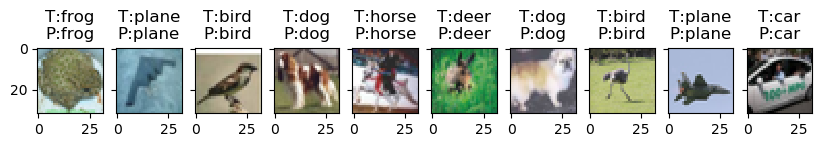

In [82]:
model = history['model']
pred_classes = predict(model, testloader)